In [23]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

import logging, sys

import tensorflow as tf
from tensorflow.python.data import Dataset

from sklearn.preprocessing import LabelEncoder

from pylab import *

logging.disable(sys.maxsize)

TRAIN_PATH = "data/X_train.csv"
TRAIN_LABEL_PATH = "data/y_train.csv"
TEST_PATH = "data/X_test.csv"
RESULT_PATH = "data/submission.csv"

train_data = pd.read_csv(TRAIN_PATH, sep=",")
train_label = pd.read_csv(TRAIN_LABEL_PATH, sep=",")


In [2]:
print(train_data.shape)


(487680, 13)


In [3]:
print(train_data.head())


  row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.

In [3]:
print(train_data["series_id"].nunique())


3810


In [4]:
print(train_label.shape)


(3810, 3)


In [6]:
print(train_label.head())


   series_id  group_id        surface
0          0        13  fine_concrete
1          1        31       concrete
2          2        20       concrete
3          3        31       concrete
4          4        22     soft_tiles


In [5]:
print(train_label["surface"].unique())


['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']


In [ ]:
print(train_label["group_id"].nunique())


In [ ]:


def transform_data(dataframe):
    return dataframe.groupby(["series_id"]).mean()



In [7]:
transformed_data = transform_data(train_data)
print(transformed_data)


           measurement_number  orientation_X  orientation_Y  orientation_Z  \
series_id                                                                    
0                        63.5      -0.758666      -0.634008      -0.105474   
1                        63.5      -0.958606       0.241867       0.031650   
2                        63.5      -0.512057      -0.846171      -0.129371   
3                        63.5      -0.939169       0.310140       0.038955   
4                        63.5      -0.891301       0.428144       0.060056   
5                        63.5       0.464712      -0.872496      -0.127264   
6                        63.5      -0.402356      -0.903141      -0.140541   
7                        63.5      -0.925909       0.347657       0.046576   
8                        63.5       0.012041      -0.988922      -0.147602   
9                        63.5       0.789137      -0.594258      -0.083210   
10                       63.5       0.848894      -0.507936     

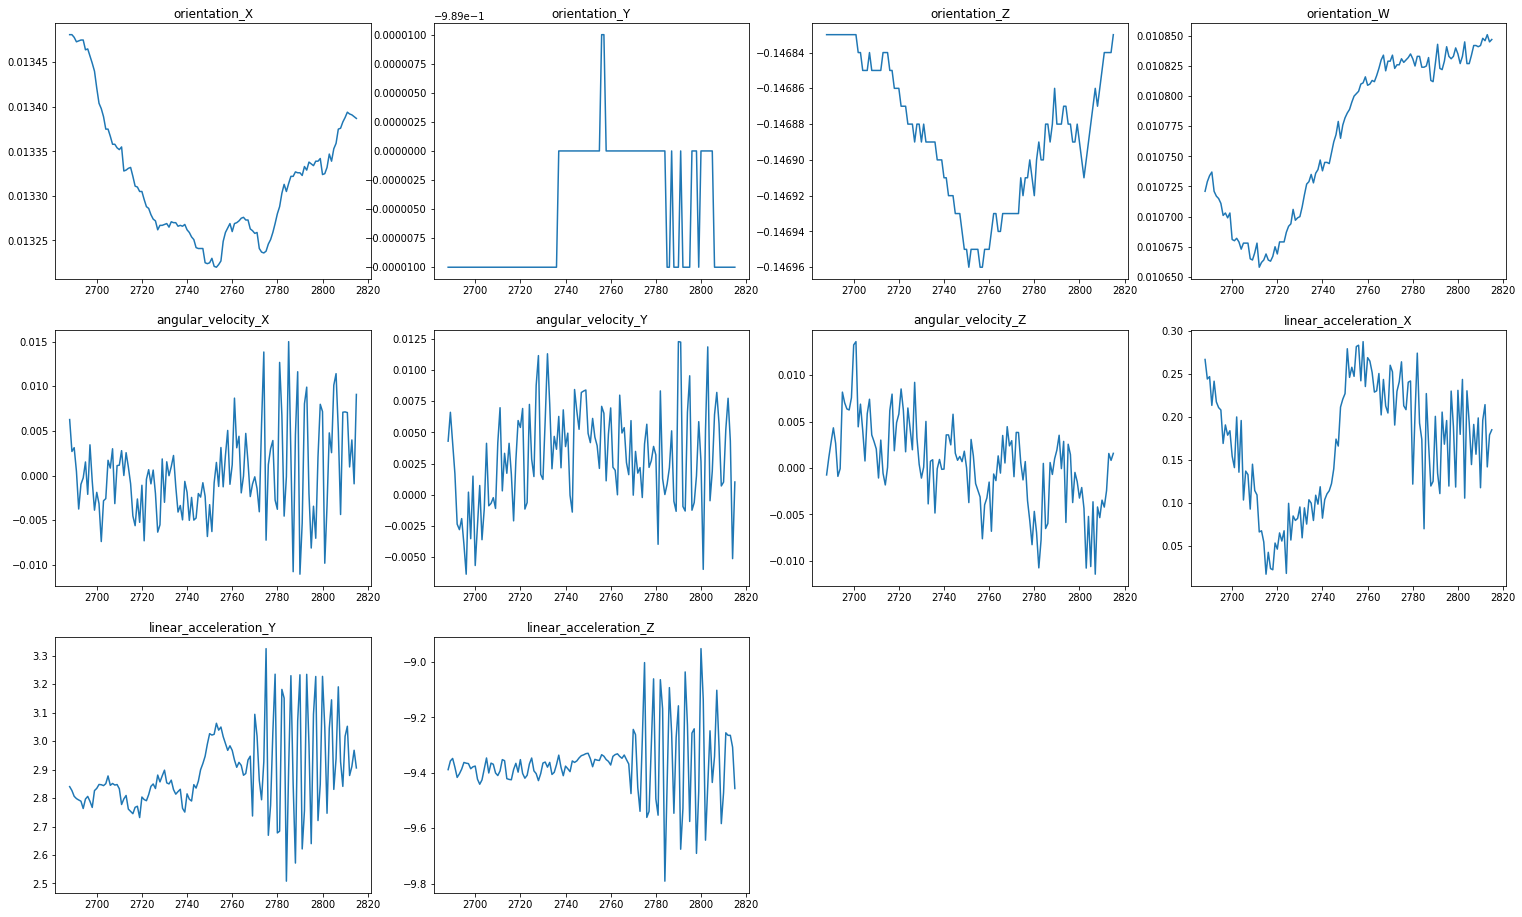

In [8]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train_data.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train_data.loc[train_data['series_id'] == 21, col])
    plt.title(col)


In [ ]:
def preprocess_features(dataframe):
    selected_features = dataframe[
        ["orientation_X",
         "orientation_Y",
         "orientation_Z",
         "orientation_W",
         "angular_velocity_X",
         "angular_velocity_Y",
         "angular_velocity_Z",
         "linear_acceleration_X",
         "linear_acceleration_Y",
         "linear_acceleration_Z"]]
    processed_features = selected_features.copy()
    return processed_features


def my_input_fn(features, targets=None, batch_size_val=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}

    if targets is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, targets)

    ds = Dataset.from_tensor_slices(inputs)
    ds = ds.batch(batch_size_val).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)

    return ds.make_one_shot_iterator().get_next()


In [ ]:

encoder = LabelEncoder()

# We separate the dataset in a training and validation set to verify if our model generalizes well (no overfiting)
train_examples = preprocess_features(transformed_data.head(3000))
train_targets = encoder.fit_transform(train_label["surface"].head(3000))

validation_examples = preprocess_features(transformed_data.tail(809))
validation_targets = encoder.fit_transform(train_label["surface"].tail(809))

# We need to tranform the different features so it can be consumed by our tensorflow model. All our features are
# categorical in our case. the indicator_column was necessary for our deep neural network but not necessary with
# shallow learning algorithms
numerical_features = [tf.feature_column.numeric_column("orientation_X")] \
                       + [tf.feature_column.numeric_column("orientation_Y")] \
                       + [tf.feature_column.numeric_column("orientation_Z")] \
                       + [tf.feature_column.numeric_column("orientation_W")]\
                       + [tf.feature_column.numeric_column("angular_velocity_X")]\
                       + [tf.feature_column.numeric_column("angular_velocity_Y")]\
                       + [tf.feature_column.numeric_column("angular_velocity_Z")]\
                       + [tf.feature_column.numeric_column("linear_acceleration_X")]\
                       + [tf.feature_column.numeric_column("linear_acceleration_Y")]\
                       + [tf.feature_column.numeric_column("linear_acceleration_Z")]

encoder.fit_transform(train_label["surface"])


In [ ]:


def train_model(
        learn_rate,
        steps_val,
        batch_size_val,
        training_examples,
        training_targets
):
    periods = 10
    steps_per_period = steps_val / periods

# Architecture of our Neural Network
    hidden_units = [81, 16, 16, 9]

    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learn_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# ToDo : Try keras to more easily add Regularization and PCA to avoid overfitting and perform dimension reduction
    linear_classifier = tf.estimator.DNNClassifier(
        n_classes=9,
        hidden_units=hidden_units,
        feature_columns=numerical_features,        
        optimizer=my_optimizer
    )

    training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets,
        batch_size_val=batch_size_val
    )

    print("Training model...")
    print("LogLoss (on training data):")

    for period in range(0, periods):
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )

        print("  period %02d" % period)

    print("Model training finished")

    return linear_classifier


def evaluate_model(model, print_results=False):
    evaluation_metrics = model.evaluate(input_fn=lambda: my_input_fn(
        validation_examples,
        validation_targets,
        num_epochs=1,
        shuffle=False
    ))

    if print_results:
        print(evaluation_metrics)

    return evaluation_metrics


In [ ]:
# Play with these (you can also try to change the architecture of the DNN) and try to consistently get a good accuracy,
# auc, precision and recall score (mostly accuracy in this case)

linear_classifier = train_model(
    learn_rate=0.00005,
    steps_val=50000000,
    batch_size_val=5,
    training_examples=train_examples,
    training_targets=train_targets
)


In [ ]:

evaluate_model(
    model=linear_classifier,
    print_results=True
)


In [ ]:
test_data = pd.read_csv(TEST_PATH, sep=",")
transformed_test_data = transform_data(test_data)


In [ ]:

results = linear_classifier.predict(
    input_fn=lambda: my_input_fn(
        features=preprocess_features(transformed_test_data),
        num_epochs=1,
        shuffle=False
    )
)
results = [result["class_ids"][0] for result in results]


In [ ]:

submission = pd.DataFrame({
    "series_id": test_data["series_id"].unique(),
    "surface": encoder.inverse_transform(results)
})

submission.to_csv(RESULT_PATH, index=False)


['carpet' 'concrete' 'fine_concrete' 'hard_tiles' 'hard_tiles_large_space'
 'soft_pvc' 'soft_tiles' 'tiled' 'wood']
